In [34]:
import time
import shap
import torch
import pickle
import statistics
import numpy as np
import pandas as pd
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict
from computer_ontology.config import*
from sklearn.feature_selection import RFECV
from computer_ontology.custom_funcs import *
from scipy.spatial.distance import squareform
from sklearn.preprocessing import MinMaxScaler
import statsmodels.stats.weightstats as stests
from sklearn.ensemble import RandomForestClassifier
from computer_ontology.featurizer import get_mordred
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.feature_selection import VarianceThreshold, f_classif, SelectKBest
from torchmetrics.classification import MultilabelF1Score, MultilabelAUROC, MultilabelPrecision, MultilabelRecall
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

In [38]:
train = pd.read_csv(expert_train_path_2025)
test = pd.read_csv(expert_test_path_2025)

train_og = pd.read_csv(alldesc_train_path_2025)
test_og = pd.read_csv(alldesc_test_path_2025)

train = train.set_index('CID')
test = test.set_index('CID')

train_og = train_og.set_index('CID')
test_og = test_og.set_index('CID')

In [39]:
train_x, train_y = x_y_split(train)
test_x, test_y = x_y_split(test)

train_og_x, train_og_y = x_y_split(train_og)
test_og_x, test_og_y = x_y_split(test_og)


In [71]:
for ind in train_y.iloc[3803].index:
    if train_y.iloc[3803][ind] == 1:
        print(ind)

Fruity
Savory
Sulfur
Woody


In [69]:
for ind in train_og_y.iloc[3803].index:
    if train_og_y.iloc[3803][ind] == 1:
        print(ind)

citrus
fruity
garlic
grapefruit
onion
sulfur
tropical
woody


In [64]:
train_og_x.iloc[3015]

'CC(=CCC/C(=C/CO)/C)C'

In [67]:
train_og_x.values.tolist().index("CC1=CCC(CC1)C(C)(C)S")

3803

In [61]:
count = 0
for i in train_og_x.values.tolist():
    count += 1
    if i == "CC(=CCC/C(=C/CO)/C)C":
        print(i)
        print(count)

CC(=CCC/C(=C/CO)/C)C
3016


In [25]:
train_x = get_mordred(train_x)
test_x = get_mordred(test_x)

100%|██████████| 1380/1380 [01:01<00:00, 22.46it/s]


In [26]:
test_x

nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A     SpAD_A   SpMAD_A  \
CID                                                                           
4              0      1   5.226252  1.847759  3.695518   5.226252  1.045250   
49             1      0   8.424292  2.135779  4.271558   8.424292  1.053037   
58             1      0   7.662988  2.052881  4.105762   7.662988  1.094713   
98             1      0   7.662988  2.052881  4.105762   7.662988  1.094713   
107            1      0  13.674401  2.166455  4.332909  13.674401  1.243127   
...          ...    ...        ...       ...       ...        ...       ...   
150030476      0      0  14.954481  2.340325  4.435619  14.954481  1.246207   
151307792      0      0  23.950224  2.344683  4.689365  23.950224  1.260538   
151986522      0      0  21.810153  2.114496  4.228991  21.810153  1.211675   
154241350      0      0  15.267203  2.389655  4.779311  15.267203  1.272267   
159578871      0      0  15.006572  2.267318  4.534637  15.006572  1.250548   

            LogEE_A     VE1_A     VE2_A  ...     SRW09     SRW10     TSRW10  \
CID                                      ...                                  
4          2.408576  2.130986  0.426197  ...  0.000000  6.834109  27.254130   
49         2.911963  2.618036  0.327255  ...  0.000000  8.297793  35.071670   
58         2.766317  2.459832  0.351405  ...  0.000000  7.890957  32.688753   
98         2.766317  2.459832  0.351405  ...  0.000000  7.890957  32.688753   
107        3.277938  3.074108  0.279464  ...  0.000000  8.594710  39.846691   
...             ...       ...       ...  ...       ...       ...        ...   
150030476  3.372197  3.048057  0.254005  ...  6.803505  8.968906  55.827060   
151307792  3.812091  3.578062  0.188319  ...  0.000000  9.448491  51.144282   
151986522  3.708016  3.471652  0.192870  ...  0.000000  8.541886  47.776976   
154241350  3.377892  3.107403  0.258950  ...  0.000000  9.424241  42.885488   
159578871  3.368808  3.193032  0.266086  ...  0.000000  9.000236  41.975403   

                   MW        AMW  WPath  WPol  Zagreb1  Zagreb2  mZagreb2  
CID                                                                        
4           75.068414   5.362030     18     2     16.0     14.0  1.333333  
49         116.047344   7.252959     65     8     32.0     33.0  1.888889  
58         102.031694   7.848592     46     6     26.0     26.0  1.777778  
98         119.988115  10.908010     46     6     26.0     26.0  1.777778  
107        150.068080   7.146099    174    10     48.0     50.0  2.583333  
...               ...        ...    ...   ...      ...      ...       ...  
150030476  183.108171   6.314075    205    14     54.0     61.0  3.027778  
151307792  262.156895   6.394071    792    26     84.0     94.0  4.805556  
151986522  258.255880   4.966459    794    17     68.0     68.0  4.750000  
154241350  222.057064   7.401902    182    19     56.0     66.0  3.041667  
159578871  170.167065   5.004914    204    15     54.0     60.0  2.944444  

[1380 rows x 773 columns]

In [27]:
train_x = train_x[selected_features_2025]
test_x = test_x[selected_features_2025]

train_x.shape

(5331, 23)

In [28]:
scaler = MinMaxScaler()

scaler.fit(train_x)

train_x = pd.DataFrame(data=scaler.transform(train_x), columns=train_x.columns)
test_x = pd.DataFrame(data=scaler.transform(test_x), columns=test_x.columns)

In [29]:
# Load the model
with open(comp_xg_path_2025, "rb") as f:
    clf = pickle.load(f)
    print("Model loaded successfully")

# Load the SHAP explainer
with open(comp_explainer_path_2025, "rb") as f:
    explainer = pickle.load(f)
    print("Explainer loaded successfully")

# Load the SHAP values
with open(comp_shap_path_2025, "rb") as f:
    shap_values = pickle.load(f)
    print("SHAP values loaded successfully")

Model loaded successfully
Explainer loaded successfully
SHAP values loaded successfully


Checking Halima's selections

In [16]:
shap_values.shape

(1380, 23, 16)

In [176]:
y_hat = pd.DataFrame(clf.predict(test_x), columns=test_y.columns)

In [180]:
for i in range(len(test_y)):
    if test_y.index[i] == cid:
        ind = i
        print(cid)
        print(i)

104453
829


Continue

In [30]:
y_hat = clf.predict_proba(test_x)

y_test = clf.predict(test_x)

y_test =  pd.DataFrame(y_test, columns=train_y.columns)
y_hat =  pd.DataFrame(y_hat, columns=train_y.columns)

check = y_hat.copy()

In [31]:
test_y

A  B  C  D  E  F  G  H  I  J  K  L  M  N  O  P
CID                                                      
4          0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
49         0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
58         0  1  0  0  0  1  1  0  0  0  0  0  0  0  0  0
98         0  0  0  0  0  0  0  0  1  0  0  0  1  1  0  0
107        0  0  1  0  1  0  1  0  0  0  0  0  0  0  1  0
...       .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. ..
150030476  0  0  0  0  0  0  1  0  0  1  0  0  0  0  0  0
151307792  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
151986522  0  0  0  0  0  0  1  1  0  1  0  0  0  0  0  0
154241350  0  0  0  0  0  0  1  0  1  0  0  0  0  1  0  0
159578871  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0

[1380 rows x 16 columns]

In [17]:
import torch 
from torchmetrics.classification import MultilabelF1Score, MultilabelAUROC, MultilabelPrecision, MultilabelRecall

In [32]:
y_hat = clf.predict(test_x)

results_per_class, y_hat = get_test_metrics_rf(clf, test_x, test_y, len(test_y.columns))

print(results_per_class.to_string())

            AUROC        F1  Precision    Recall
A        0.659429  0.404762   0.485714  0.346939
B        0.674819  0.486275   0.529915  0.449275
C        0.726494  0.647120   0.674672  0.621730
D        0.654029  0.422330   0.446154  0.400922
E        0.702355  0.526971   0.569507  0.490348
F        0.664019  0.421569   0.505882  0.361345
G        0.717981  0.646245   0.670082  0.624046
H        0.708859  0.515406   0.557576  0.479167
I        0.756446  0.606335   0.697917  0.536000
J        0.720628  0.654369   0.693416  0.619485
K        0.699158  0.503704   0.596491  0.435897
L        0.708253  0.563107   0.610526  0.522523
M        0.641302  0.355140   0.431818  0.301587
N        0.885479  0.750000   0.709091  0.795918
O        0.696117  0.526733   0.588496  0.476703
P        0.558067  0.183908   0.320000  0.129032
Average  0.698340  0.513373   0.567954  0.474432


/home/akshay/computer_ontology/notebooks/computer_ontology/custom_funcs.py:227: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_per_class = results_per_class.fillna(0)


In [33]:
results_per_class.drop(['Average', 'N']).sum(axis=0)/results_per_class.drop(['Average', 'N']).shape[0]

AUROC        0.685864
F1           0.497598
Precision    0.558544
Recall       0.453000
dtype: float64

In [22]:
results_per_class.drop(['Average', 'Sulfur']).sum(axis=0)/results_per_class.drop(['Average', 'Sulfur']).shape[0]

AUROC        0.679057
F1           0.489866
Precision    0.549143
Recall       0.448815
dtype: float64

In [27]:
odor = '4'
ind = 470

In [ ]:
alldesc_test_y = pd.read_csv(alldesc_test_path)
for i in alldesc_test_y[alldesc_test_y["CID"] == cid]["Descriptors"]:
    print(i)

cinnamon;fruity;citrus;floral;rose;balsam


In [228]:
print('test_y is',test_y[odor][test_y[odor].index[ind]])
print('y_hat is',y_hat[odor][y_hat[odor].index[ind]])

test_y is 1
y_hat is 1.00827585e-07


In [182]:
predicted_class = (check[odor] >= 0.9999).astype(int) # For Truest positives
predicted_class

0       0
1       0
2       0
3       0
4       0
       ..
1308    0
1309    0
1310    0
1311    0
1312    0
Name: 9, Length: 1313, dtype: int64

In [214]:

predicted_class = (check[odor] >= 0.000001).astype(int) # For Falsest negatives
predicted_class

0       1
1       0
2       0
3       1
4       1
       ..
1308    1
1309    0
1310    1
1311    1
1312    1
Name: 9, Length: 1313, dtype: int64

Checking for misclassifications (ignore if not using)

In [ ]:

predicted_class = (check[odor] >= 0.1).astype(int) # For Falsest negatives
predicted_class

In [ ]:
for i in range(check[odor].size):
  if predicted_class[i] == 0: # 1 if +ve, else -ve
    if predicted_class[i] != test_y[odor][test_y[odor].index[i]]: # == for True X, != False X
      print("absolute index:",i)
      print("CID:",test_y[odor].index[i])
      CID = test_y[odor].index[i]
      

Resume

In [215]:
for i in range(check[odor].size):
  if predicted_class[i] == 0: # 1 if +ve, else -ve
    if predicted_class[i] != test_y[odor][test_y[odor].index[i]]: # == for True X, != False X
      print("absolute index:",i)
      print("CID:",test_y[odor].index[i])

absolute index: 6
CID: 179
absolute index: 178
CID: 8129
absolute index: 208
CID: 8723
absolute index: 215
CID: 8858
absolute index: 264
CID: 11086
absolute index: 529
CID: 61092
absolute index: 536
CID: 61153
absolute index: 543
CID: 61209
absolute index: 892
CID: 118225


In [122]:
test_y

alcohol  animal  aquatic  earthy  flower  fruity  green  herbal  \
CID                                                                          
49               0       0        0       0       0       1      0       0   
58               0       0        0       0       0       0      0       0   
98               0       0        0       0       0       0      0       0   
135              0       0        0       0       0       0      0       0   
176              0       0        0       0       0       0      0       0   
...            ...     ...      ...     ...     ...     ...    ...     ...   
137481702        0       0        0       0       0       1      0       0   
140029897        0       0        0       0       0       1      0       0   
140045973        1       0        0       0       0       1      1       0   
148920341        0       0        0       0       0       0      0       1   
154735146        0       0        0       0       1       0      1       0   

           savory  spices  woody  
CID                               
49              0       0      0  
58              1       0      0  
98              1       0      0  
135             1       0      0  
176             1       0      0  
...           ...     ...    ...  
137481702       0       0      0  
140029897       0       0      0  
140045973       0       0      0  
148920341       0       0      0  
154735146       0       0      0  

[1313 rows x 11 columns]

In [15]:
shap_values.shape

(1313, 87, 11)

In [185]:
test_y.columns[4]

'flower'

In [186]:
ind

829

In [17]:
shap.initjs()

In [187]:
shap.force_plot(shap.TreeExplainer(clf).expected_value, shap_values[ind,:,4], feature_names=test_x.columns)

In [32]:
test_y.columns

Index(['Alcohol', 'Animal Body', 'Aquatic', 'Balsamic', 'Chemicals', 'Earthy',
       'Flower', 'Fruity', 'Gourmand', 'Green', 'Herbal', 'Savory', 'Smoky',
       'Spices', 'Sulfur', 'Woody'],
      dtype='object')

In [33]:
import matplotlib.pyplot as plt

for class_idx, class_name in enumerate(test_y.columns):
    print(f"Plotting and saving SHAP summary for class: {class_name}")
    shap.summary_plot(shap_values[:, :, class_idx], test_x, show=False)
    plt.title(f"SHAP Summary - {class_name}")
    plt.savefig(f"{class_name}_shap.png", bbox_inches='tight')
    plt.close()

Plotting and saving SHAP summary for class: Alcohol
Plotting and saving SHAP summary for class: Animal Body
Plotting and saving SHAP summary for class: Aquatic
Plotting and saving SHAP summary for class: Balsamic
Plotting and saving SHAP summary for class: Chemicals
Plotting and saving SHAP summary for class: Earthy
Plotting and saving SHAP summary for class: Flower
Plotting and saving SHAP summary for class: Fruity
Plotting and saving SHAP summary for class: Gourmand
Plotting and saving SHAP summary for class: Green
Plotting and saving SHAP summary for class: Herbal
Plotting and saving SHAP summary for class: Savory
Plotting and saving SHAP summary for class: Smoky
Plotting and saving SHAP summary for class: Spices
Plotting and saving SHAP summary for class: Sulfur
Plotting and saving SHAP summary for class: Woody


Plotting SHAP summary for class: Alcohol


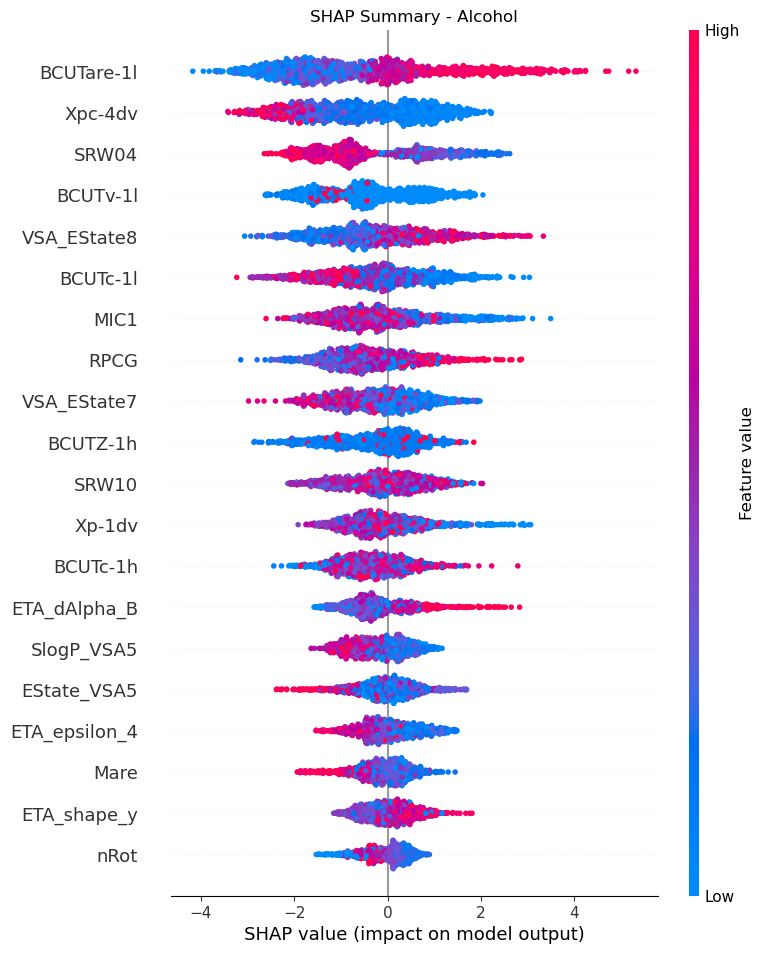

Plotting SHAP summary for class: Animal Body


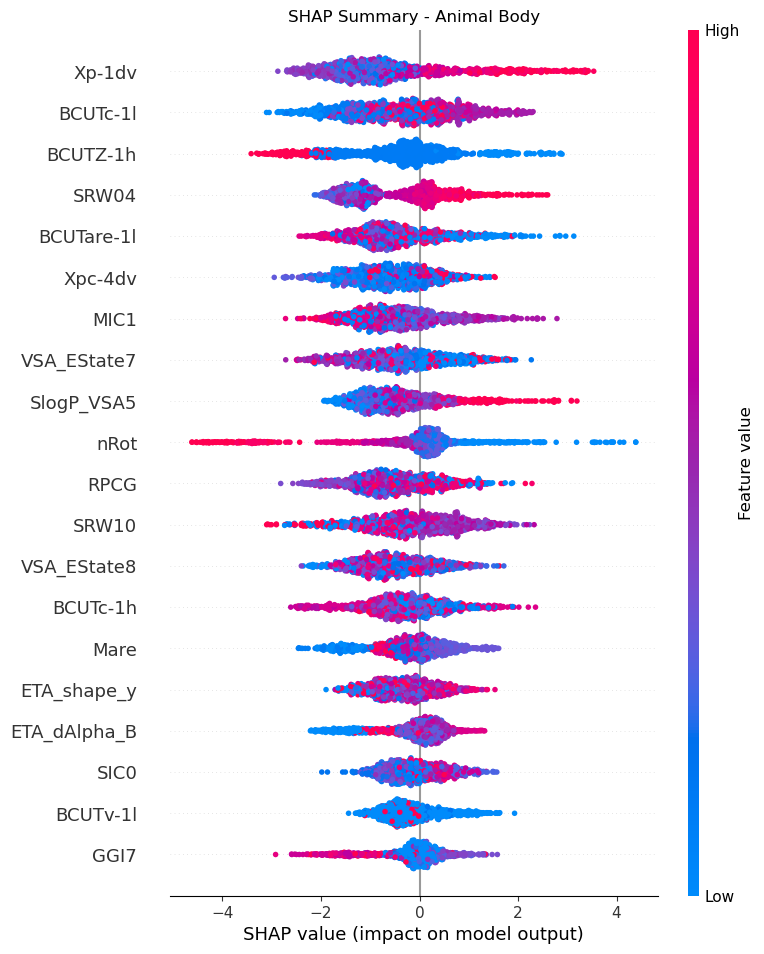

Plotting SHAP summary for class: Aquatic


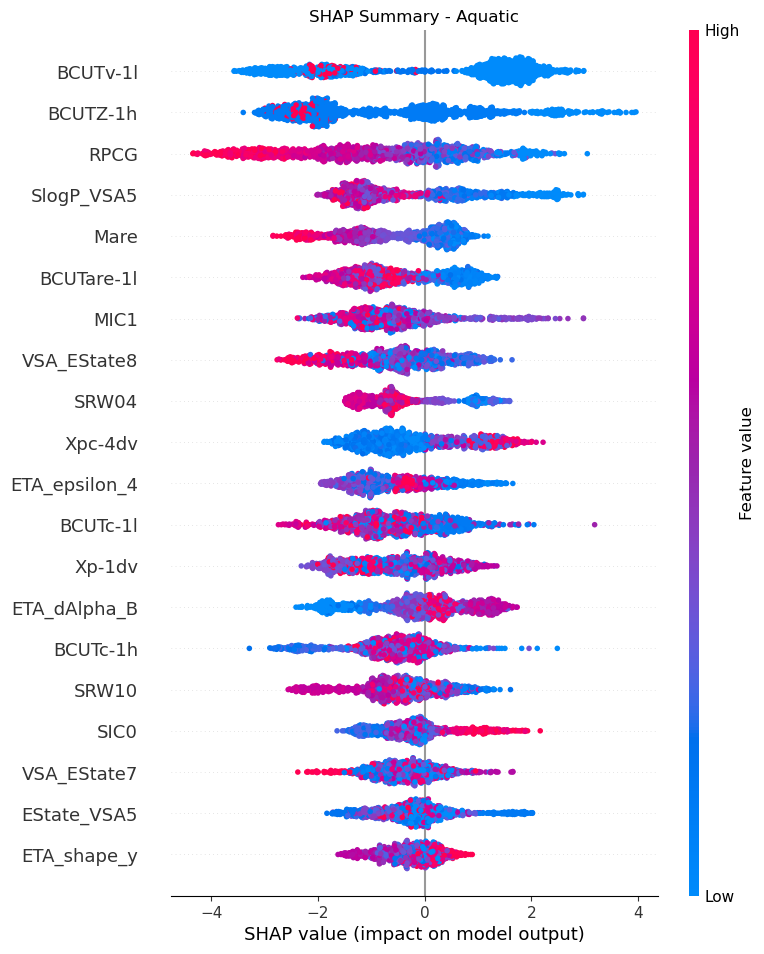

Plotting SHAP summary for class: Balsamic


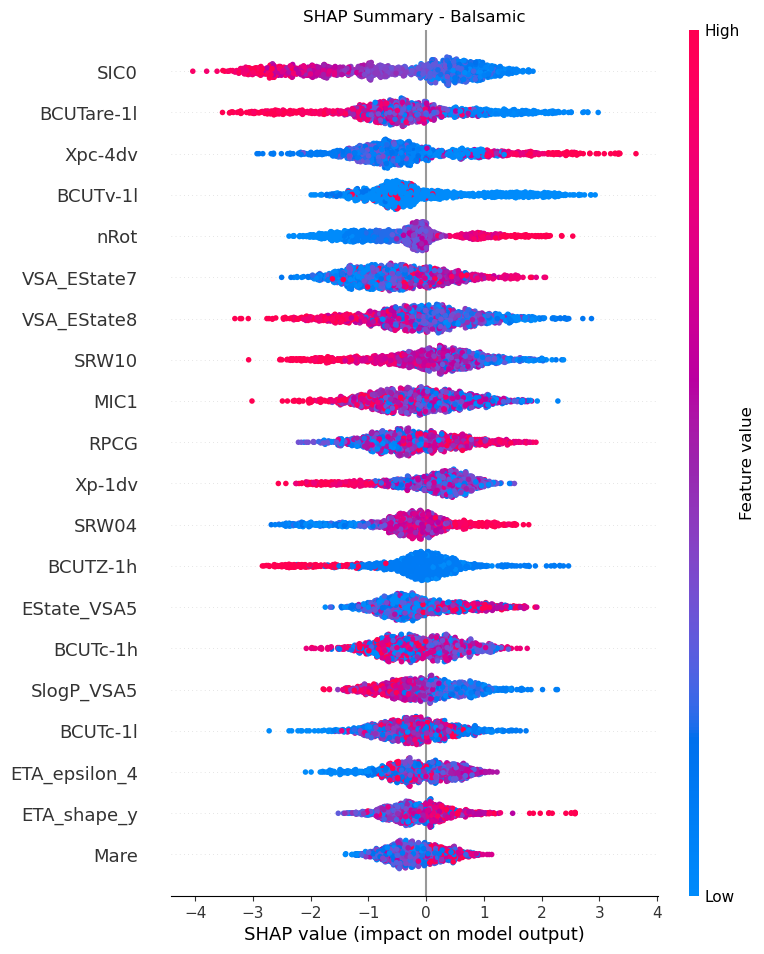

Plotting SHAP summary for class: Chemicals


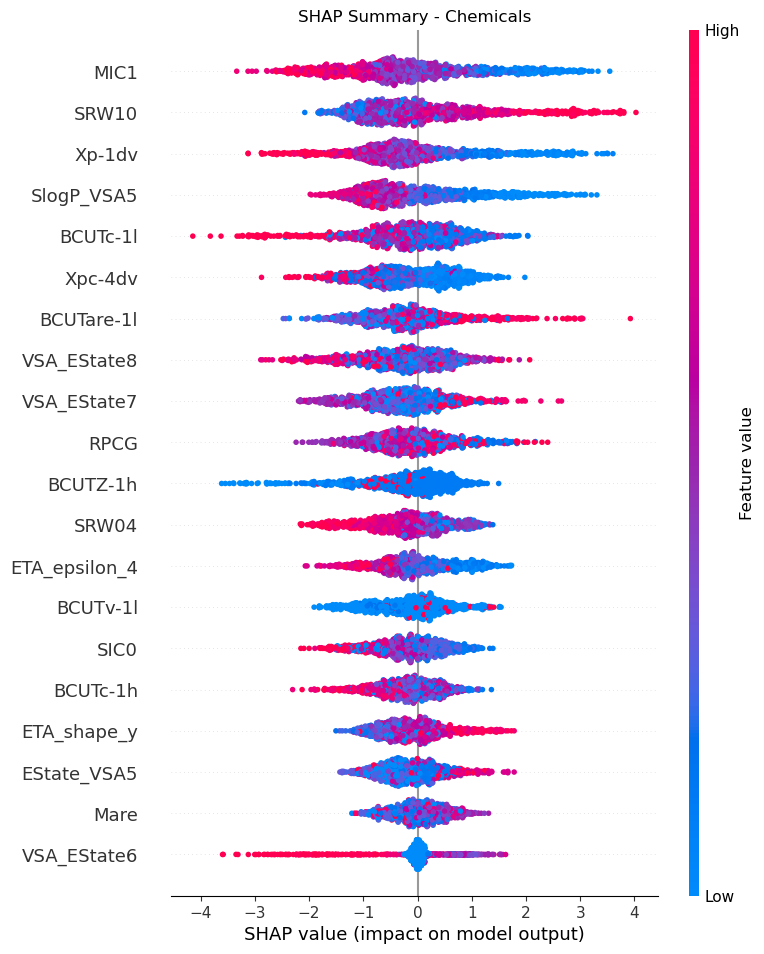

Plotting SHAP summary for class: Earthy


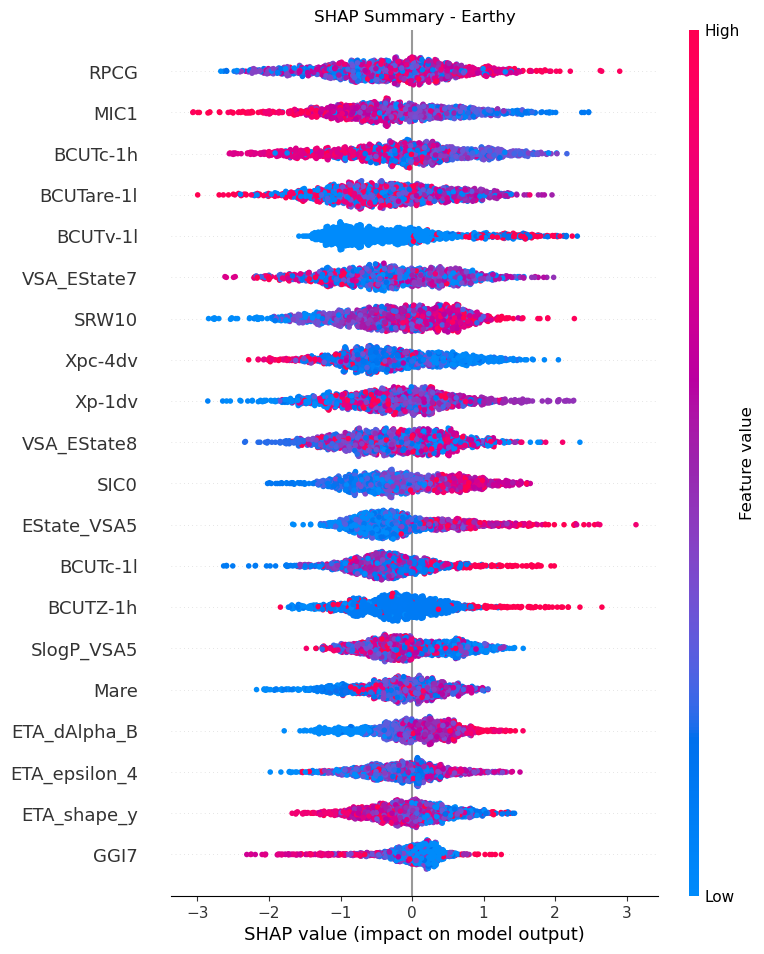

Plotting SHAP summary for class: Flower


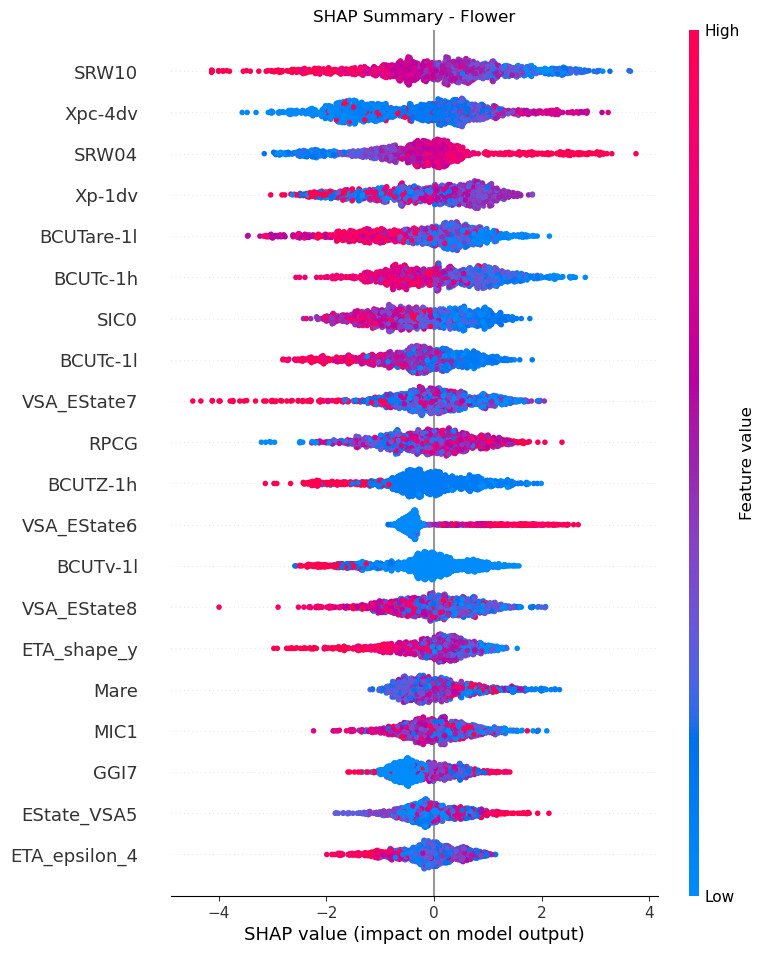

Plotting SHAP summary for class: Fruity


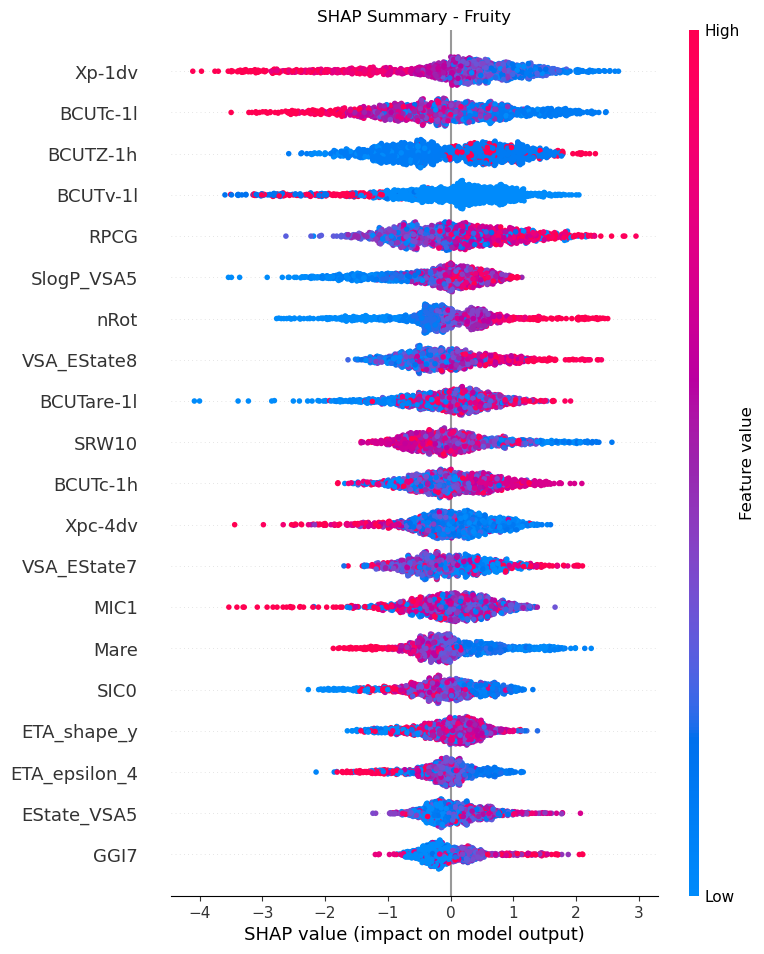

Plotting SHAP summary for class: Gourmand


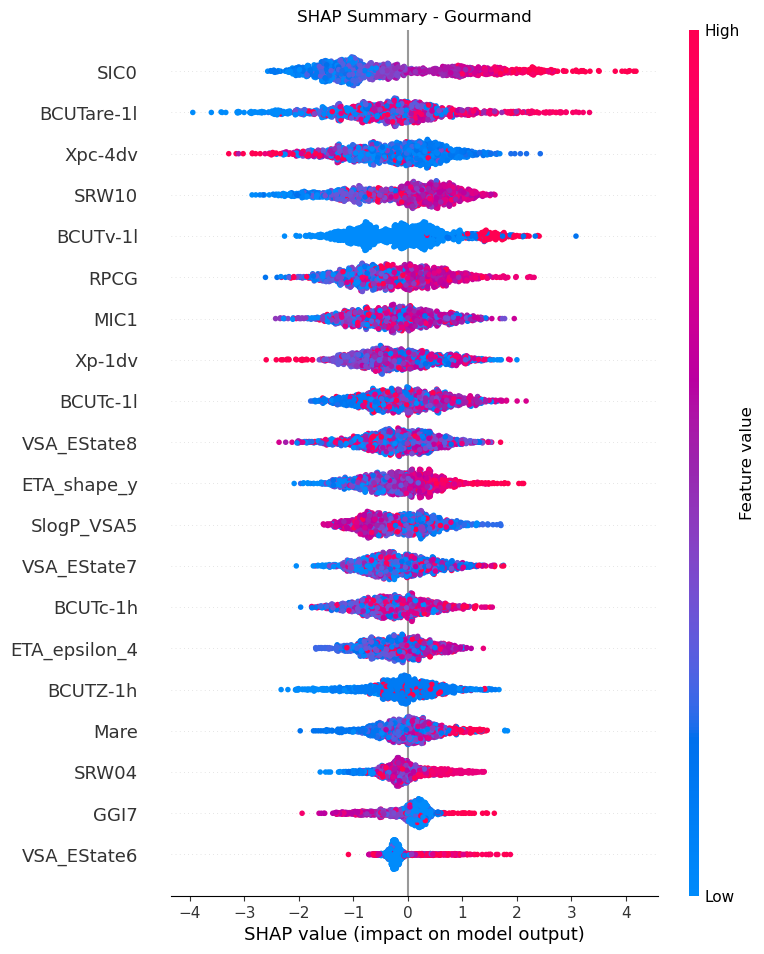

Plotting SHAP summary for class: Green


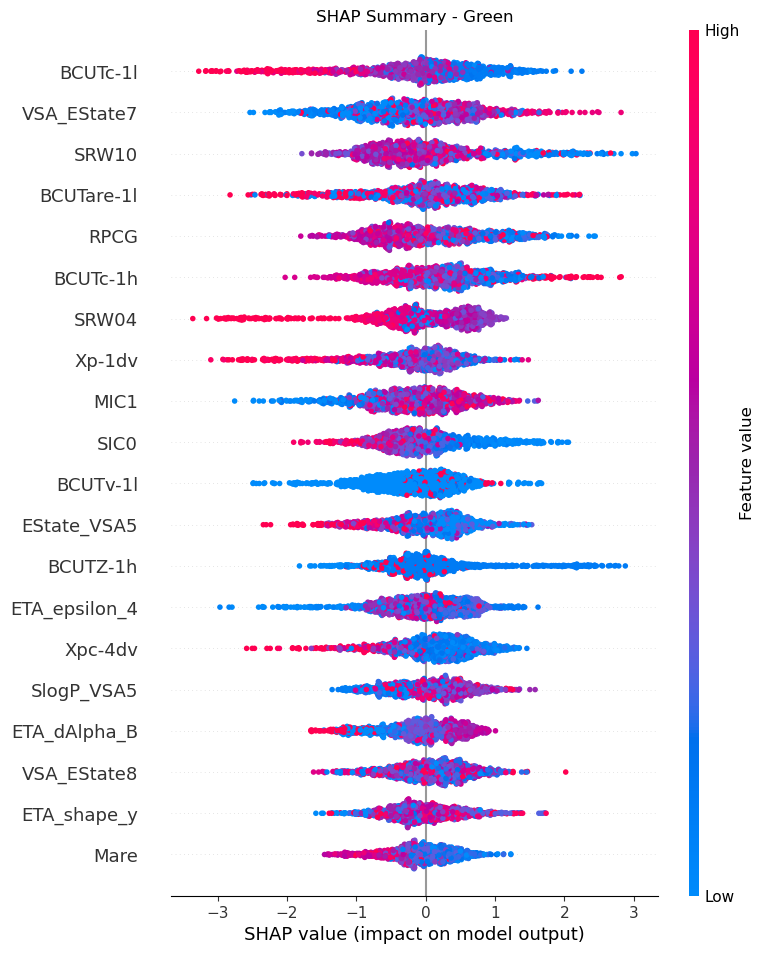

Plotting SHAP summary for class: Herbal


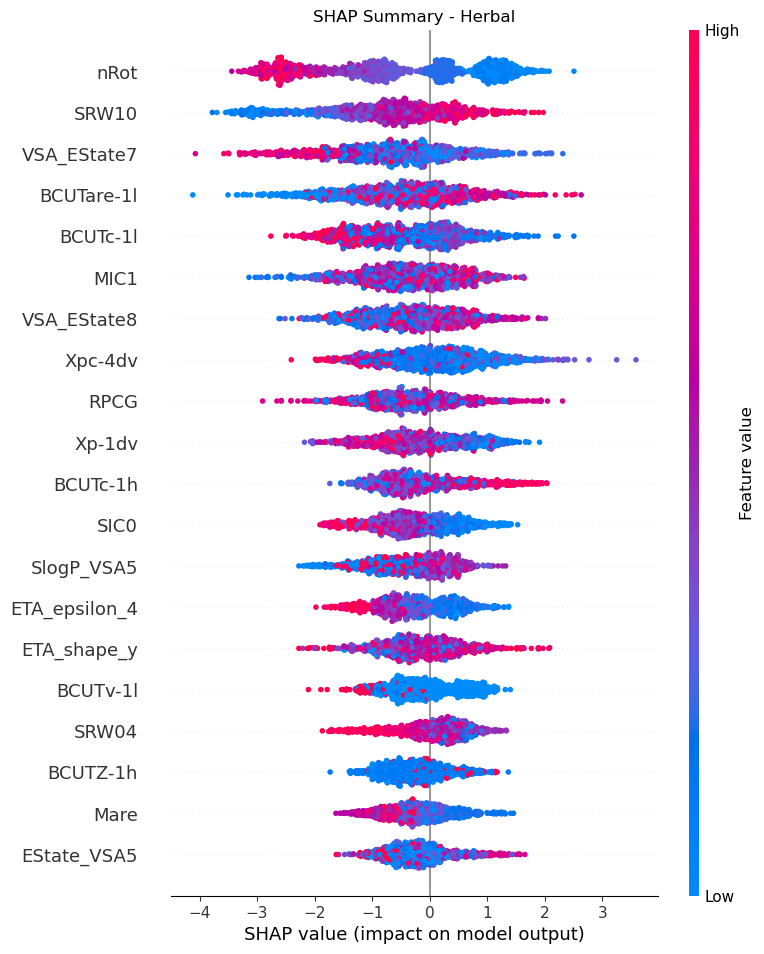

Plotting SHAP summary for class: Savory


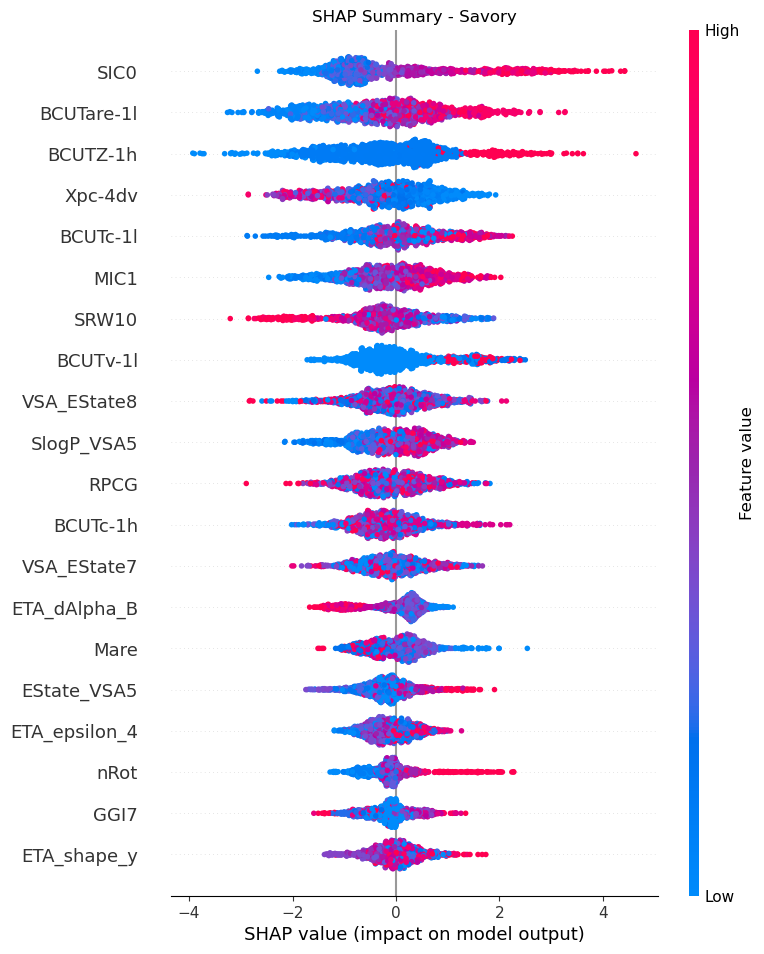

Plotting SHAP summary for class: Smoky


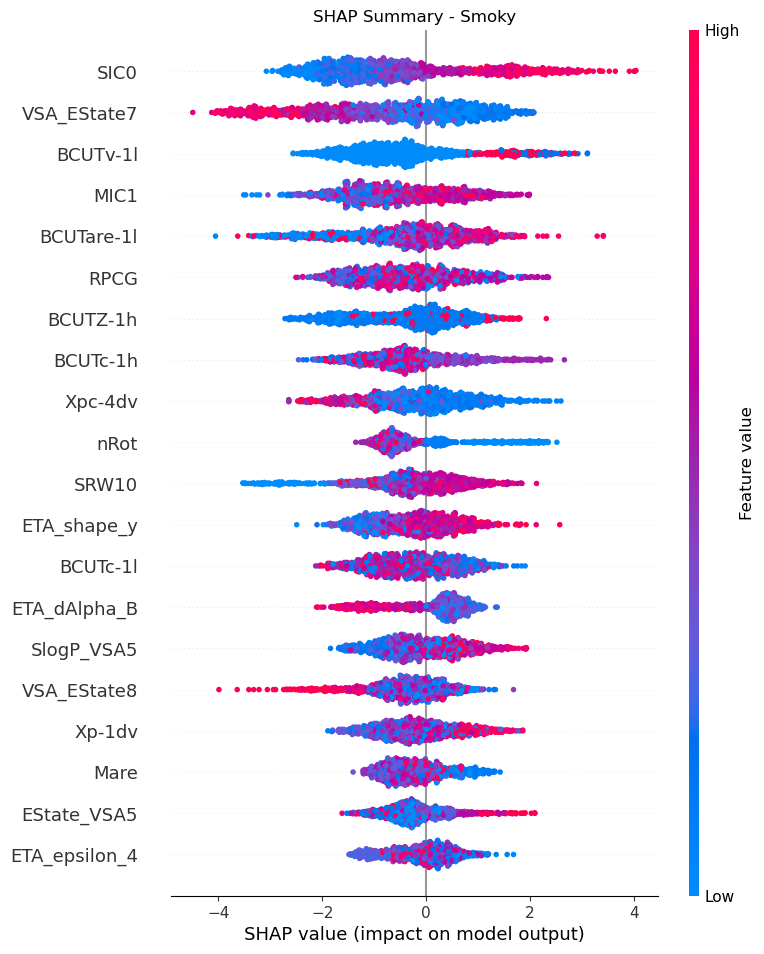

Plotting SHAP summary for class: Spices


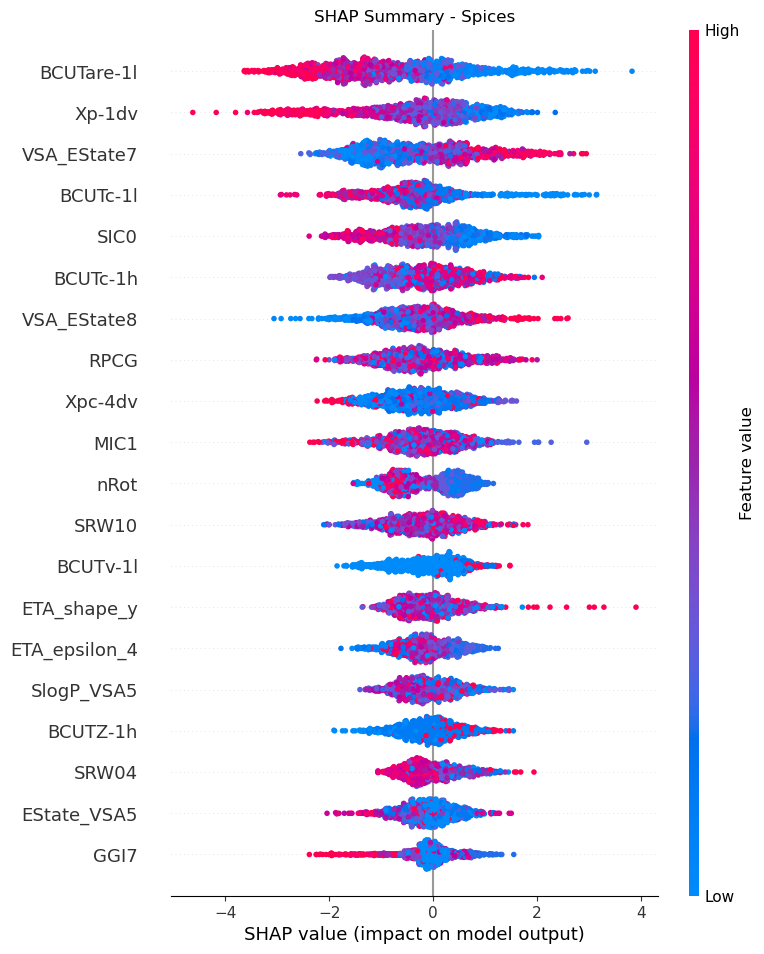

Plotting SHAP summary for class: Sulfur


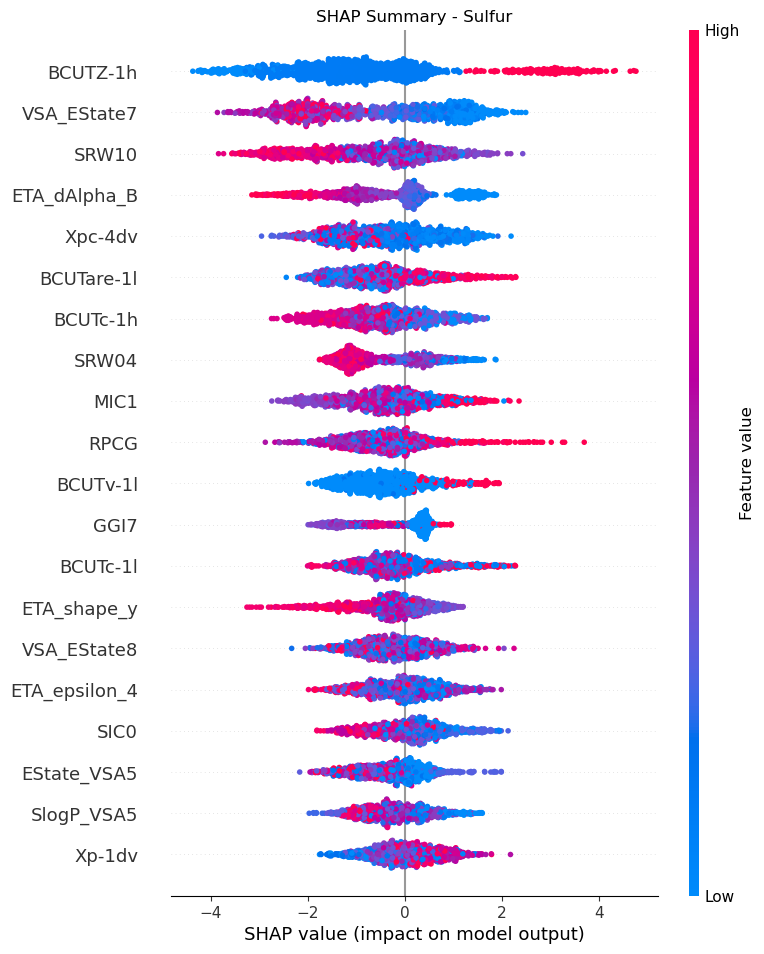

Plotting SHAP summary for class: Woody


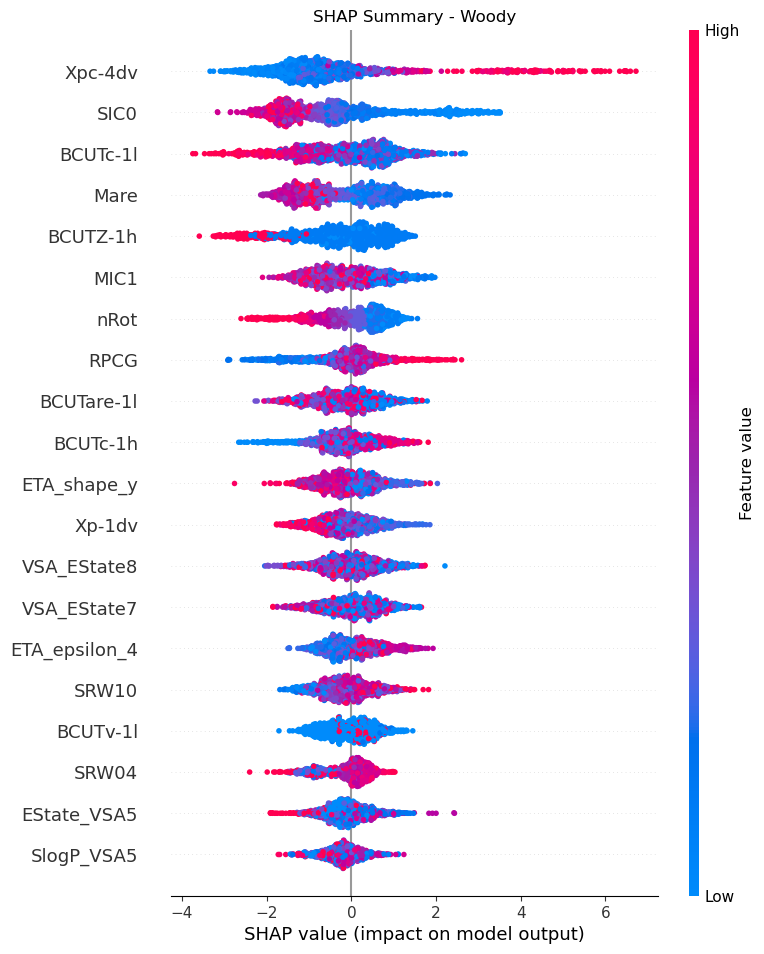

In [11]:
import matplotlib.pyplot as plt

for class_idx, class_name in enumerate(test_y.columns):
    print(f"Plotting SHAP summary for class: {class_name}")
    shap.summary_plot(shap_values[:, :, class_idx], test_x, show=False)
    plt.title(f"SHAP Summary - {class_name}")
    plt.show()

Class: Flower
  Plotting TP (264 instances)


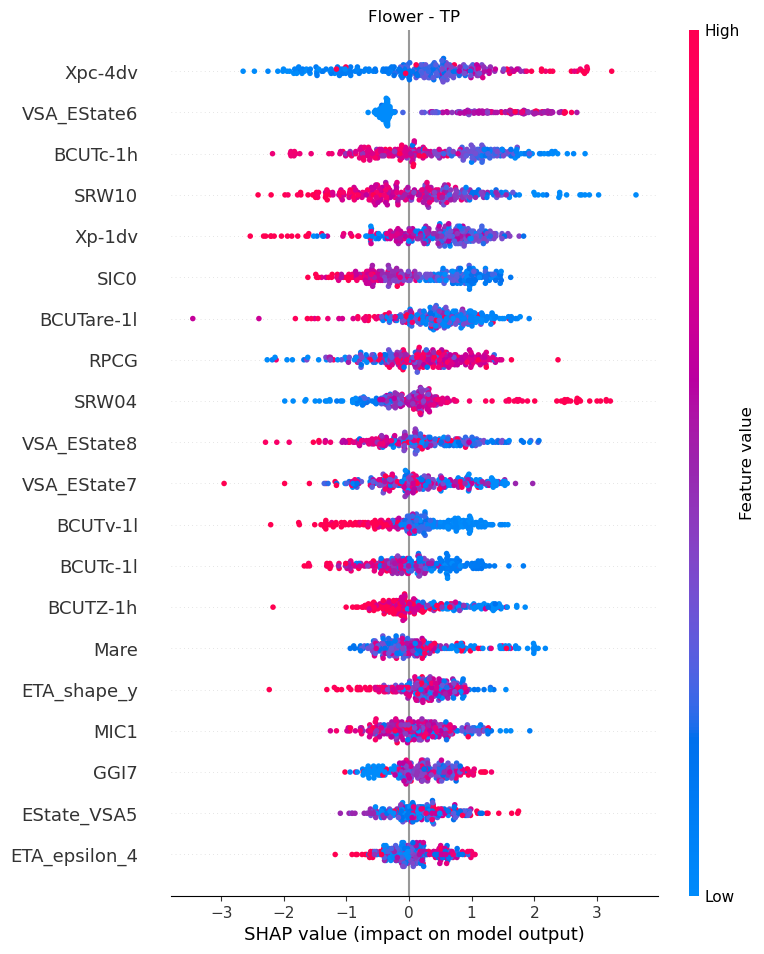

  Plotting FP (131 instances)


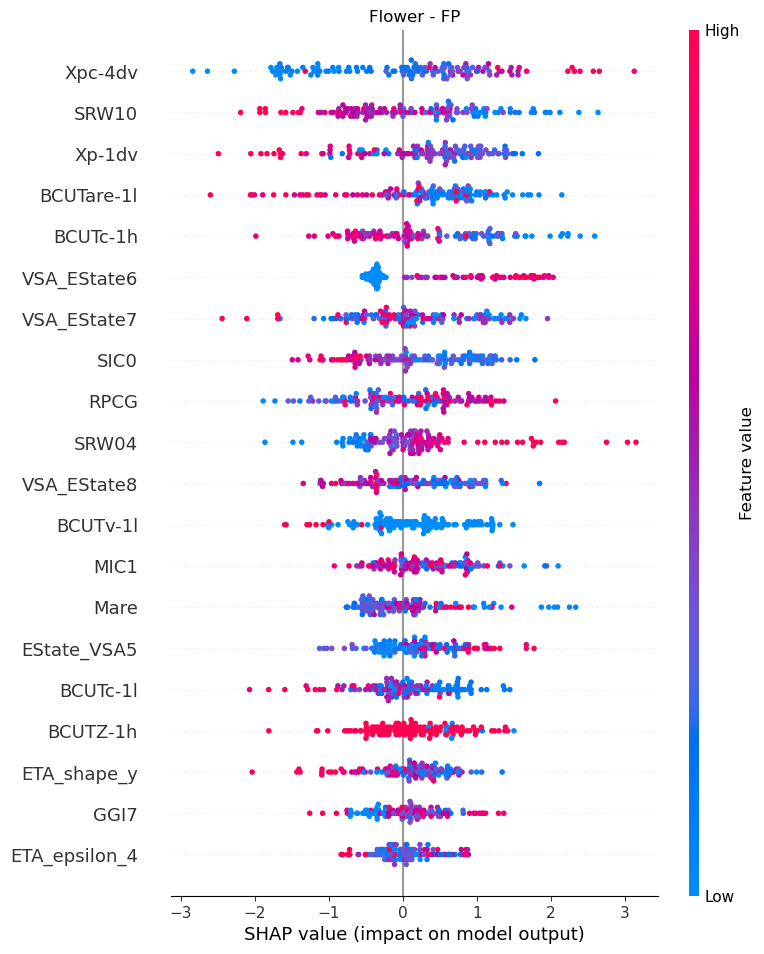

  Plotting TN (832 instances)


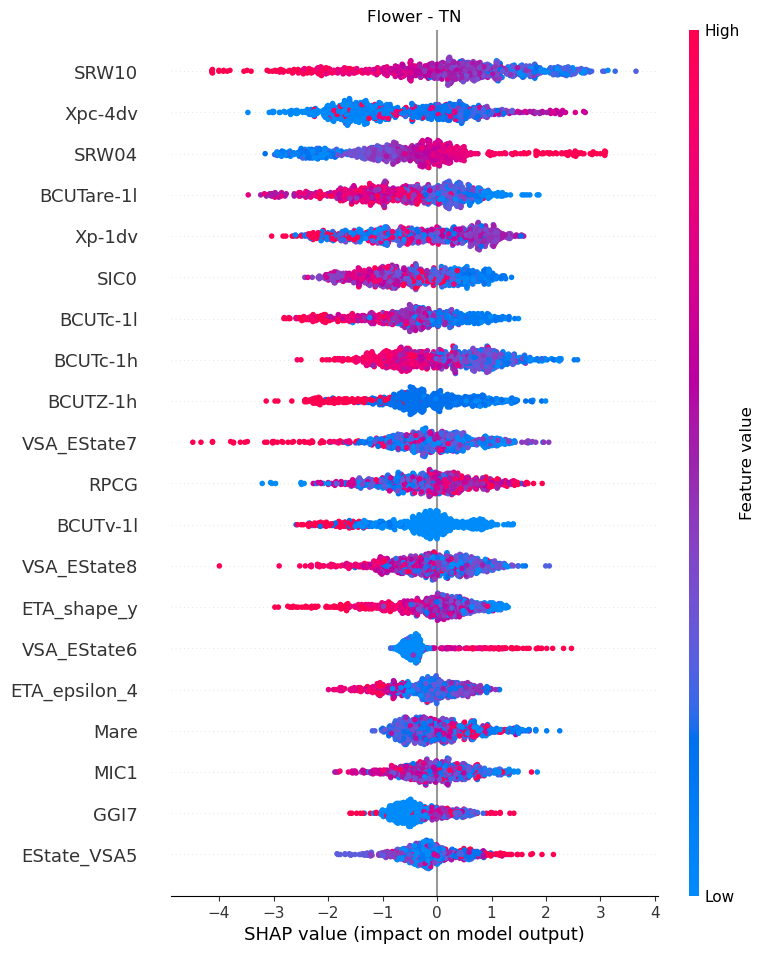

  Plotting FN (153 instances)


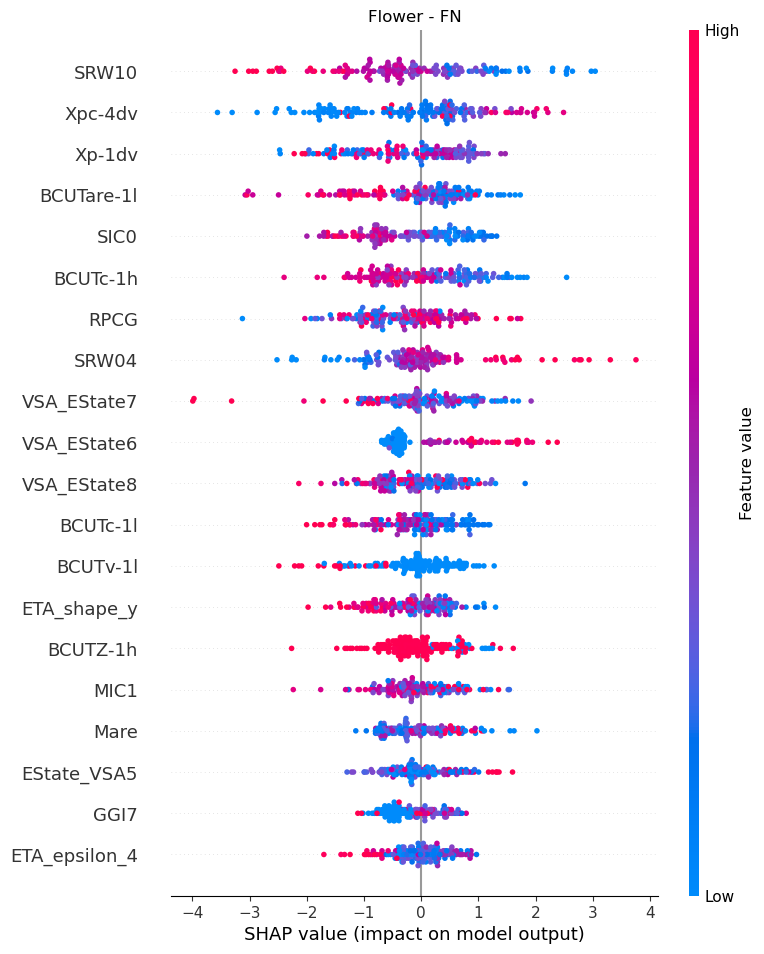

Class: Fruity
  Plotting TP (450 instances)


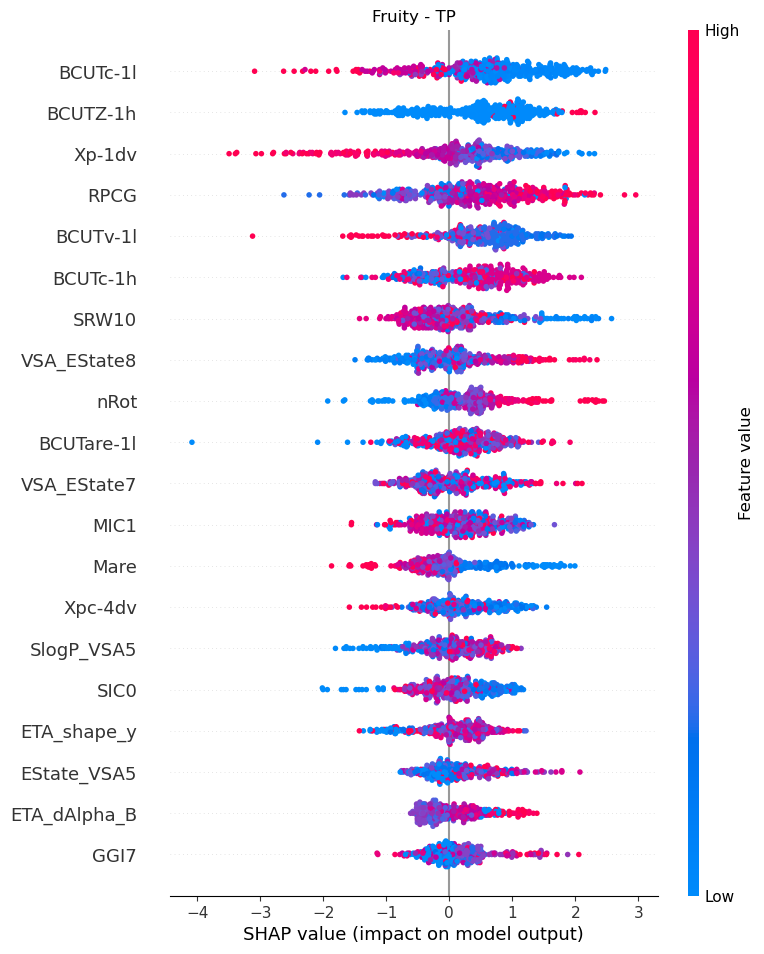

  Plotting FP (151 instances)


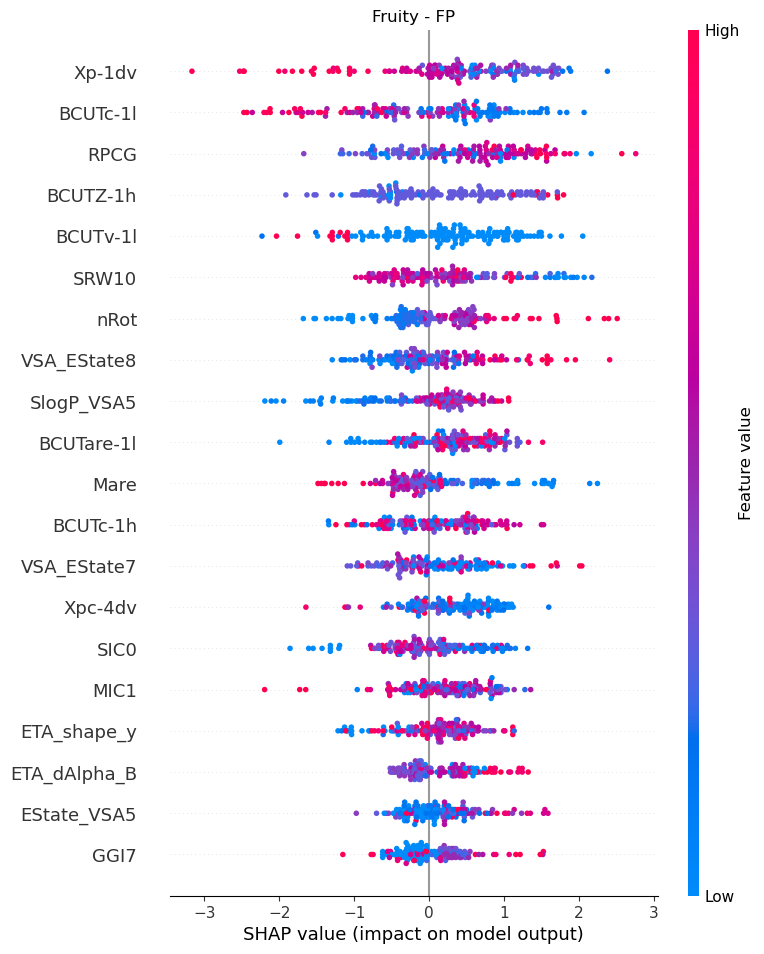

  Plotting TN (572 instances)


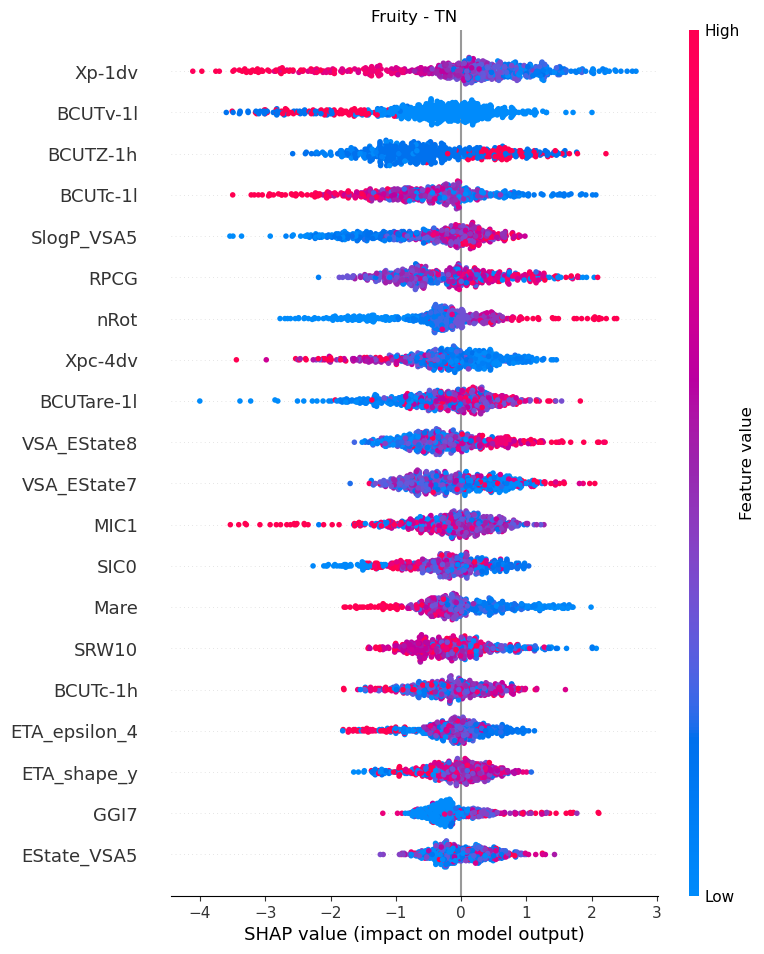

  Plotting FN (207 instances)


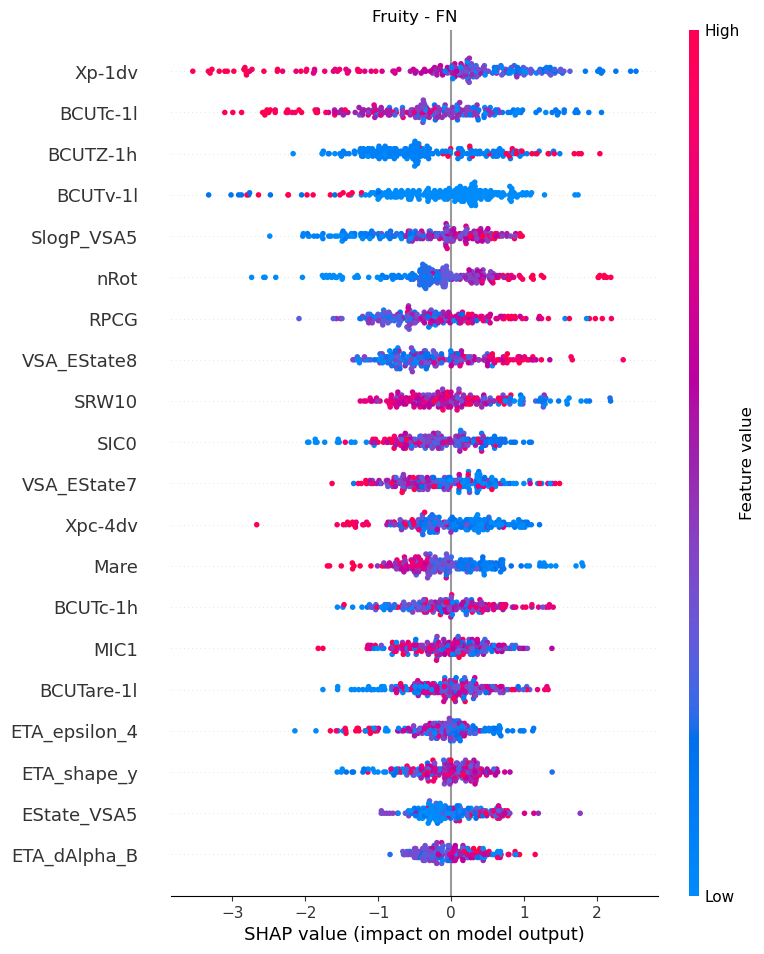

In [12]:
import matplotlib.pyplot as plt

# Specify the classes you want to plot, e.g.:
selected_classes = ['Flower', 'Fruity']  # <-- change this list as needed

for class_name in selected_classes:
    if class_name not in test_y.columns:
        print(f"Class {class_name} not found in test_y columns.")
        continue

    class_idx = test_y.columns.get_loc(class_name)
    print(f"Class: {class_name}")

    y_true = test_y[class_name].values
    y_pred = y_test[class_name].values

    tp_idx = np.where((y_true == 1) & (y_pred == 1))[0]
    fp_idx = np.where((y_true == 0) & (y_pred == 1))[0]
    tn_idx = np.where((y_true == 0) & (y_pred == 0))[0]
    fn_idx = np.where((y_true == 1) & (y_pred == 0))[0]

    for label, idx in zip(['TP', 'FP', 'TN', 'FN'], [tp_idx, fp_idx, tn_idx, fn_idx]):
        if len(idx) == 0:
            print(f"  No {label} instances for {class_name}")
            continue
        print(f"  Plotting {label} ({len(idx)} instances)")
        shap.summary_plot(shap_values[idx, :, class_idx], test_x.iloc[idx], show=False)
        plt.title(f"{class_name} - {label}")
        plt.show()

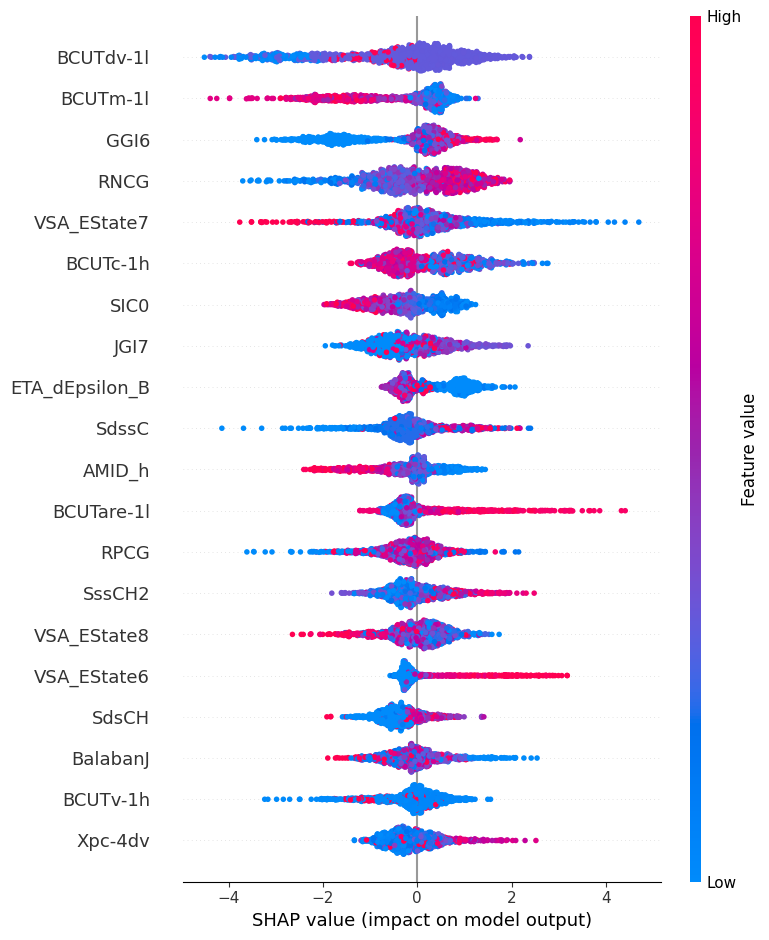

In [26]:
shap.summary_plot(shap_values[:,:,4], test_x)